# HarvestStat Data Analysis - Central African Republic

## Issue 1: suspicious data

In [30]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Congo, The Democratic Republic of the',
    'product': ['R011','R012','R013','R014','R015','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df[
    (df['fnid'].isin(['CD1997A20601','CD2015A114']))
].pivot_table(index='season_date', columns=['product','indicator'], values='value')

product         Beans (mixed)      Cassava                          \
indicator   Quantity Produced Area Planted Quantity Produced Yield   
season_date                                                          
2005-01-01             1593.0          NaN          460476.0   NaN   
2006-01-01             1505.0          NaN          459234.0   NaN   
2007-01-01             1422.0          NaN          457995.0   NaN   
2008-01-01             1343.0          NaN          456760.0   NaN   
2009-01-01             1269.0          NaN          455528.0   NaN   
2010-01-01             1199.0          NaN          454299.0   NaN   
2011-01-01             1133.0          NaN          453074.0   NaN   
2013-01-01                NaN    314742.73         3336273.0  10.6   
2014-01-01                NaN    331117.26         3509843.0  10.6   
2015-01-01                NaN    341722.18         3622255.2  10.6   
2016-01-01                NaN    399865.52         4238574.6  10.6   

product     Cooking Banana (unspecified)                              \
indicator                   Area Planted Quantity Produced     Yield   
season_date                                                            
2005-01-01                           NaN             376.0       NaN   
2006-01-01                           NaN            2131.0       NaN   
2007-01-01                           NaN            2135.0       NaN   
2008-01-01                           NaN            2139.0       NaN   
2009-01-01                           NaN            2143.0       NaN   
2010-01-01                           NaN            2147.0       NaN   
2011-01-01                           NaN            2151.0       NaN   
2013-01-01                      21303.05           97781.0  4.590000   
2014-01-01                      22459.69          103090.0  4.590001   
2015-01-01                      22674.24          145987.0  6.438452   
2016-01-01                      32217.64          147879.0  4.590001   

product     Maize (Corn)                             Rice (Paddy)  \
indicator   Area Planted Quantity Produced     Yield Area Planted   
season_date                                                         
2005-01-01           NaN          35928.00       NaN          NaN   
2006-01-01           NaN          35935.00       NaN          NaN   
2007-01-01           NaN          35942.00       NaN          NaN   
2008-01-01           NaN          35949.00       NaN          NaN   
2009-01-01           NaN          35956.00       NaN          NaN   
2010-01-01           NaN          35963.00       NaN          NaN   
2011-01-01           NaN          35970.00       NaN          NaN   
2013-01-01     107456.14         122500.00  1.140000     23218.75   
2014-01-01     102631.57         117000.00  1.140000     29193.75   
2015-01-01     174207.60         198596.67  1.140000  17396875.00   
2016-01-01     151691.22          58928.00  0.388473  87921875.00   

product                                    
indicator   Quantity Produced       Yield  
season_date                                
2005-01-01              992.0         NaN  
2006-01-01              994.0         NaN  
2007-01-01              996.0         NaN  
2008-01-01              998.0         NaN  
2009-01-01             1000.0         NaN  
2010-01-01             1002.0         NaN  
2011-01-01             1004.0         NaN  
2013-01-01          2972000.0  128.000000  
2014-01-01            37368.0    1.280000  
2015-01-01            22268.0    0.001280  
2016-01-01            11254.0    0.000128

## Validation with FAOSTAT and CHIRPS Precipitation

Main-Cassava Correlation:
           FAO        HS      PRCP
FAO   1.000000  0.999713 -0.159300
HS    0.999713  1.000000  0.711719
PRCP -0.159300  0.711719  1.000000


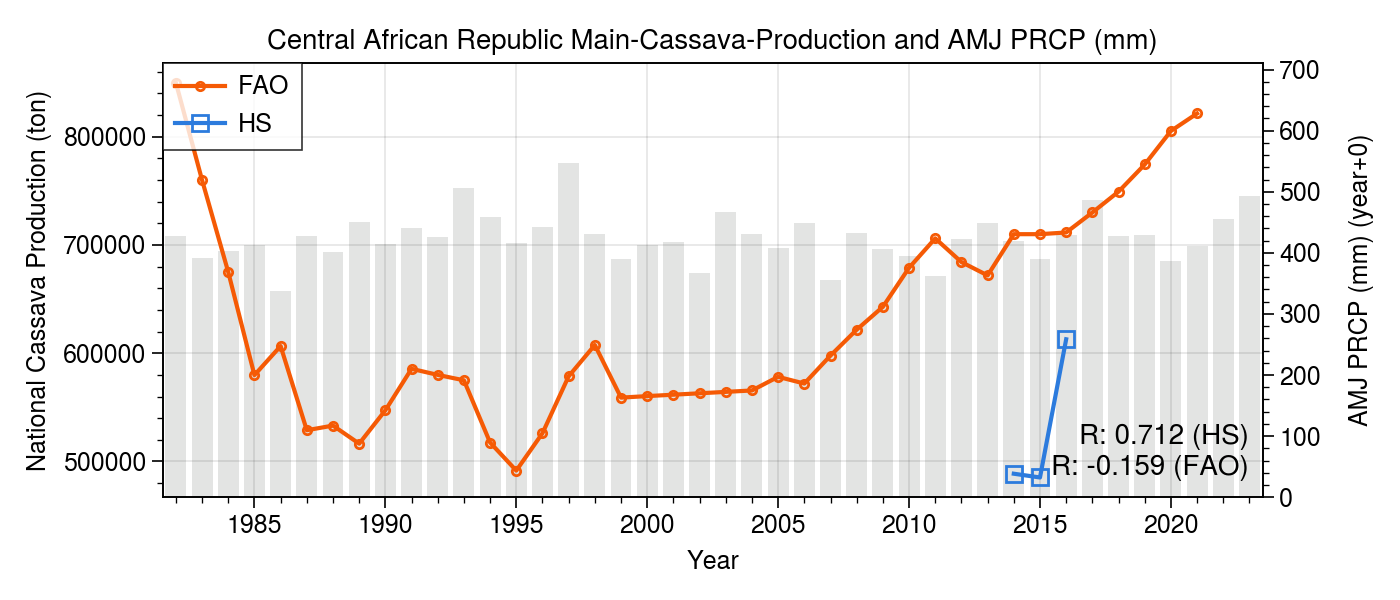

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import proplot as pplot
# Load Crop Data ------------------------------------- #
country_name, season_name, product_name_fdw, product_name_fao,  = 'Central African Republic', 'Main', 'Cassava', 'Cassava'
# country_name, season_name, product_name_fdw, product_name_fao,  = 'Central African Republic', 'Main', 'Maize', 'Maize (corn)'
shape_code, prcp_start_month, prcp_season_name, prcp_year_offset = 'CF2003A0', 4, 'AMJ PRCP (mm)', +0
# HarvestStat
df = pd.read_csv('../public/hvstat_data.csv', index_col=0)
df = df[
    (df['country'] == country_name) &
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name_fdw])) &
    (df['indicator'] == 'production')
].copy()
df['year'] = df['harvest_year']
data_hs = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').squeeze()
# FAO-STAT
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == country_name) &
    (df['cpc2_name'] == product_name_fao) &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# Merge
data = pd.concat([data_fao,data_hs], axis=1, keys=['FAO','HS']).sort_index()
data = data.reindex(np.array(range(1982,2024)))
# ---------------------------------------------------- #
# Load precipitation --------------------------------- #
fn = '../data/prcp_chirps-v2.hdf'
prcp_nat = pd.read_hdf(fn)[shape_code].resample('1M').agg('sum')
prcp_nat.index = prcp_nat.index.map(lambda x: x.replace(day=1))
prcp_nat.name = 'PRCP'
prcp_nat.index = prcp_nat.index + pd.DateOffset(years=prcp_year_offset)
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = prcp_season_name
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'{season_name}-{product_name_fdw} Correlation:\n{corr_value}')
# ---------------------------------------------------- #
# Comparison with Precipitation ---------------------- #
fig, ax1 = plt.subplots(figsize=(7,3))
fig.set_facecolor('white')
data.plot(ax=ax1, grid=True, markerfacecolor='None',color=['#F55A05','#2C7BDD'])
marker = ['.','s']
for i, line in enumerate(ax1.get_lines()):
    line.set_marker(marker[i])
# years = data.index
# ax1.set_xticks(years)
# ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.set_xlim([data.index[0]-0.5, data.index[-1]+0.5])
ax1.set_xlabel('Year')
ax1.set_ylabel('National %s Production (ton)' % product_name_fdw)
ax1.patch.set_facecolor('white')
# Precipitation
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label + ' (year+%d)'%prcp_year_offset, labelpad=10)
ax2.grid(False)
ax1.set_zorder(1)  
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(loc='upper left')
ax1.annotate(
    'R: %.3f (HS)\nR: %.3f (FAO)' % (corr_value.loc['HS','PRCP'], corr_value.loc['FAO','PRCP']), 
    xy=(1, 0.2), xycoords='axes fraction', fontsize=10,
    xytext=(-5, -5), textcoords='offset points',
    ha='right', va='top'
)
title = f'{country_name} {season_name}-{product_name_fdw}-Production and {prcp_label}'
ax1.set_title(title)
fig.tight_layout()
plt.show()
# ---------------------------------------------------- #